In [1]:
### Change Point Model ###
from change_detection import ChangePointDetector
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
import sys 
sys.path.append('../../../')
from main import Manager 
m = Manager('../../../')
from bin.plots.volume_oi_chart import price_volume_oi_chart
from bin.utils.tools import pretty_print

2025-04-29 23:20:54,545 - bin.options.optgd.db_connect - INFO - Options DB Initialized
2025-04-29 23:20:54,546 - bin.options.optgd.db_connect - WARNING - You currently have 8 connections open.
2025-04-29 23:20:54,547 - INFO - PriceDB Initialized successfully at 2025-04-29 23:20:54.547710
2025-04-29 23:20:54,547 - bin.price.db_connect - INFO - PriceDB Initialized successfully at 2025-04-29 23:20:54.547710
2025-04-29 23:20:54,548 - INFO - Established 3 database connections
2025-04-29 23:20:54,548 - bin.price.db_connect - INFO - Established 3 database connections
2025-04-29 23:20:54,595 - bin.alerts.options_alerts - INFO - Notifications instance initialized.


In [3]:
def get_aligned(stock):
    price_df = m.Pricedb.ohlc(stock)
    price_df =price_df.resample('1D').last()
    d = m.Optionsdb.get_daily_option_stats(stock)
    d = d.resample('1D').last()
    price_df = price_df.loc[d.index].dropna()
    d = d.loc[price_df.index].dropna()
    return price_df, d

def plot_model(stock, column):
    price_df, d = get_aligned(stock)
    df = d[column].sort_index().dropna().copy()
    detector = ChangePointDetector(df, scale=True, period=3, window_size=30)  # Adjusted window_size to 20 for better sensitivity
    # Optimized parameters
    best_params, best_result = detector.optimize_parameters(
        sensitivity_range=(0.01, 0.9, 0.01),
        threshold_range=(0.1, 2.0, 0.1), 
        min_triggers=4, 
        max_triggers=30
    )
    # print("\nBest Parameters:")
    # print(best_params)
    # print(f"Triggers: {best_result['Signal'].sum()}")

    best_params['Hits'] = best_result['Signal'].sum()
    best_params['threshold'] = best_result['S_T'].quantile(0.85)

    title_text = f"{stock.upper()} {df.name} - Change Point Detection\n" \
                f"Best Parameters: {best_params}"

    fig, ax = plt.subplots(2,1, figsize=(5, 5), height_ratios=[1, 0.5])
    ax[0].set_title(title_text)
    ax[0].plot(df.index, df.values, color='blue', linewidth=1)
    ax[1].plot(best_result.index, best_result['S_T'], linewidth=1, color='red', label='S_T')
    ax[1].hlines(best_params['threshold'], xmin=best_result.index[0], xmax=best_result.index[-1], color='green', linestyle='--', label='Threshold')

    # Scatter plot the change points
    for i in range(len(best_result)):
        if best_result['Signal'][i] == 1:
            ax[0].scatter(df.index[i], df.values[i], color='red', s=50, label='Change Point')


    fig.tight_layout()
    fig.autofmt_xdate()
    return price_df, d, best_result


In [4]:
from trend_results import TResults
tr = TResults(
    connections = '../../../',
    lookback_days= 90,
    window_size = 200, 
    period = 30
    
    )


2025-04-29 23:21:00,098 - bin.options.optgd.db_connect - INFO - Options DB Initialized
2025-04-29 23:21:00,099 - bin.options.optgd.db_connect - WARNING - You currently have 8 connections open.
2025-04-29 23:21:00,102 - INFO - PriceDB Initialized successfully at 2025-04-29 23:21:00.102000
2025-04-29 23:21:00,102 - bin.price.db_connect - INFO - PriceDB Initialized successfully at 2025-04-29 23:21:00.102000
2025-04-29 23:21:00,102 - INFO - Established 3 database connections
2025-04-29 23:21:00,102 - bin.price.db_connect - INFO - Established 3 database connections


2025-04-29 23:21:00,253 - bin.alerts.options_alerts - INFO - Notifications instance initialized.


In [5]:
results = tr.analyze_stocks()

Processing gdx:   0%|          | 0/184 [00:00<?, ?it/s]  

Processing nvo: 100%|██████████| 184/184 [00:09<00:00, 18.71it/s, Success=1]


In [7]:
# Convert to DataFrame
data = []
for i in results:
    for result in i:
        data.append({
            'stock': result.stock,
            'metric': result.name,
            'trend_direction': result.trend_direction,
            'seasonality': result.seasonality,
            'slope': result.slope,
            'change_point': result.change_point
        })
df = pd.DataFrame(data)

# Flag slope discrepancies (where trend direction and slope sign don't match)
df['slope_discrepancy'] = ((df['trend_direction'] == 'up') & (df['slope'] < 0)) | ((df['trend_direction'] == 'down') & (df['slope'] > 0))
print("DataFrame with Slope Discrepancies Flagged:")
df[df.slope_discrepancy == True]

DataFrame with Slope Discrepancies Flagged:


,stock,metric,trend_direction,seasonality,slope,change_point,slope_discrepancy
2,gdx,options_volume,up,normal,-0.000935,0,True
7,gdx,call_volume,up,normal,-0.001087,0,True
8,gdx,put_volume,up,high,-0.000718,0,True
11,gme,options_volume,up,normal,-0.000411,0,True
12,gme,oi,up,normal,-0.001367,0,True
...,...,...,...,...,...,...,...
1564,tost,call_volume,down,normal,0.020285,0,True
1565,tost,put_volume,down,normal,0.002061,0,True
1568,pct,options_volume,down,normal,0.090091,0,True
1573,pct,call_volume,down,normal,0.093507,0,True


In [8]:
df.metric.unique()

array(['close_prices', 'stock_volume', 'options_volume', 'oi', 'atm_iv',
       'call_oi', 'put_oi', 'call_volume', 'put_volume'], dtype=object)

In [14]:
increasing_oi = df[(df.metric == 'oi') & (df.trend_direction == 'up')].stock.tolist()
increasing_call_oi = df[(df.metric == 'call_oi') & (df.trend_direction == 'up')].stock.tolist()
decreasing_oi = df[(df.metric == 'oi') & (df.trend_direction == 'down')].stock.tolist()

increasing_options_volume = df[(df.metric == 'options_volume') & (df.trend_direction == 'up')].stock.tolist()
increasing_call_volume = df[(df.metric == 'call_volume') & (df.trend_direction == 'up')].stock.tolist()
decreasing_options_volume = df[(df.metric == 'options_volume') & (df.trend_direction == 'down')].stock.tolist()

increasing_price_volume = df[(df.metric == 'price_volume') & (df.trend_direction == 'up')].stock.tolist()
decreasing_price_volume = df[(df.metric == 'price_volume') & (df.trend_direction == 'down')].stock.tolist()

increasing_price = df[(df.metric == 'close_prices') & (df.trend_direction == 'up')].stock.tolist()
decreasing_price = df[(df.metric == 'close_prices') & (df.trend_direction == 'down')].stock.tolist()
print("Increasing Options Volume:", increasing_options_volume)
print("Increasing Call OI:", increasing_call_oi)
print("Increasing Call Volume:", increasing_call_volume)
print("Increasing Price:", increasing_price)



Increasing Options Volume: ['gdx', 'gme', 'xlf', 'pfe', 'aal', 'igv', 'uwmc', 'vxx', 'smh', 'shy', 'jks', 'slv', 'abbv', 'moo', 'rkt', 'nflx', 'pbw', 'ief', 'sono', 'xly', 'xlp', 'xlb', 'xlre', 'ibb', 'jets', 'tlt', 'hsbc', 'ba', 'ge', 'xrt', 'aa', 'cvs', 'icln', 'fang', 'tsn', 'lulu', 'itb', 'tbt', 'c', 'gld', 'x', 'tan', 'eog', 'tmv', 'kre', 'djt', 'fxy', 'dltr', 'btu']
Increasing Call OI: ['gme', 'amzn', 'spy', 'aapl', 'aal', 'dkng', 'mdb', 'cvx', 'intc', 'smh', 'mu', 'shy', 'bno', 'wfc', 'slv', 'qcom', 'tsla', 'sol', 'mos', 'tgt', 'meta', 'abbv', 'moo', 'rkt', 'qqq', 'nflx', 'pbw', 'ief', 'sono', 'xly', 'xlp', 'xlb', 'xlre', 'bito', 'ibb', 'clsk', 'jets', 'xlc', 'hsbc', 'kr', 'afrm', 'wba', 'ba', 'ge', 'xrt', 'aa', 'icln', 'ctra', 'run', 'tsn', 'iwm', 'lulu', 'itb', 'tbt', 'c', 'gld', 'weat', 'v', 'x', 'eog', 'clx', 'jpm', 'tmv', 'sony', 'hood', 'pgr', 'afl', 'aig', 'kre', 'avgo', 'sofi', 'mpw', 'arm', 'ttd', 'amat', 'tdoc', 'rddt', 'dell', 'fxy', 'dltr', 'orcl', 'u', 'pct', 'btu']

In [16]:
b = set(increasing_options_volume) & set(increasing_price) & set(increasing_call_volume) & set(increasing_call_oi)
print(b)

{'gld', 'icln', 'tbt', 'fxy', 'x', 'rkt', 'slv', 'shy', 'dltr', 'tmv', 'tsn', 'ief'}


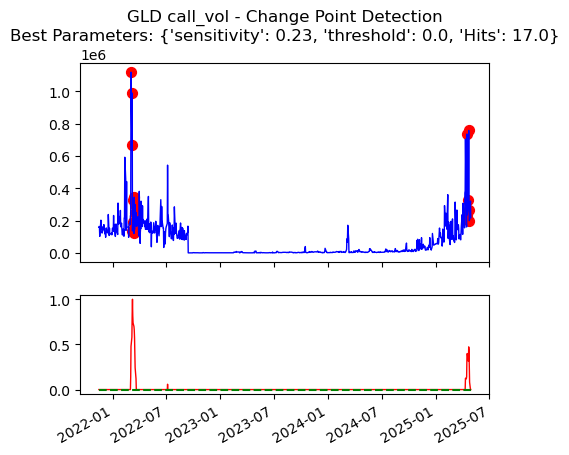

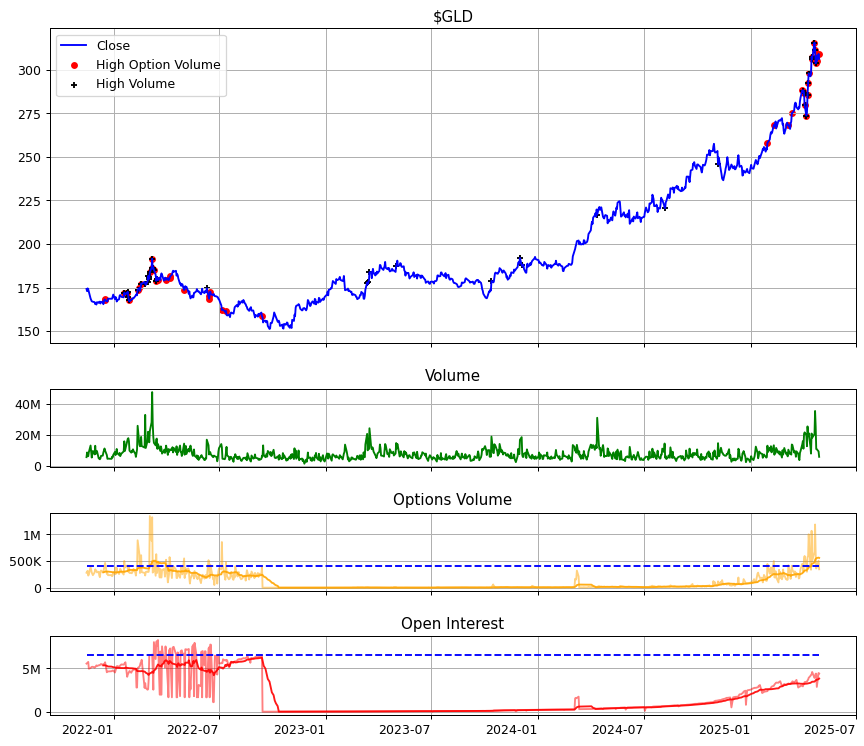

In [18]:
stock = 'gld'; column = 'call_vol'
pdf, odf, result = plot_model(stock, column)
pdf.columns = [x.lower() for x in pdf.columns]
fig, ax = plt.subplots(4, 1, height_ratios=[2, 0.5, 0.5, 0.5], figsize = (10, 10), dpi = 90)
price_volume_oi_chart(odf, pdf, fig, ax, stock = stock)
fig.show()

In [19]:

pretty_print(odf[['total_vol', 'call_vol_chng', 'put_vol_chng', 'total_oi', 'call_oi_chng', 'put_oi_chng']])

,total_vol,call_vol_chng,put_vol_chng,total_oi,call_oi_chng,put_oi_chng
date,,,,,,
2021-11-15,"280,176.00","-13,166.00","-22,336.00","5,559,162.00","43,880.00","27,848.00"
2021-11-16,"302,094.00","4,598.00","17,320.00","5,607,026.00","29,384.00","18,480.00"
2021-11-17,"315,592.00","-3,308.00","16,806.00","5,671,014.00","24,248.00","39,740.00"
2021-11-18,"226,862.00","-58,340.00","-30,390.00","5,750,662.00","35,486.00","44,162.00"
2021-11-19,"247,614.00","31,172.00","-10,420.00","4,970,048.00","-344,476.00","-436,138.00"
...,...,...,...,...,...,...
2025-04-23,"641,915.00","-490,170.00","-50,692.00","4,388,878.00","150,777.00","172,523.00"
2025-04-24,"359,288.00","-69,024.00","-213,603.00","4,394,100.00","24,902.00","-19,680.00"
2025-04-25,"410,126.00","7,652.00","43,186.00","2,864,092.00","-837,444.00","-692,564.00"


In [20]:
df[df.stock == stock]

,stock,metric,trend_direction,seasonality,slope,change_point,slope_discrepancy
1134,gld,close_prices,up,normal,0.002726,0,False
1135,gld,stock_volume,up,low,0.026925,0,False
1136,gld,options_volume,up,high,-0.000874,0,True
1137,gld,oi,up,normal,-0.000777,0,True
1138,gld,atm_iv,up,normal,-0.000232,0,True
1139,gld,call_oi,up,normal,-0.000920,0,True
1140,gld,put_oi,up,normal,-0.000596,0,True
1141,gld,call_volume,up,high,-0.000870,0,True
1142,gld,put_volume,up,normal,-0.000880,0,True


In [21]:
result['S_T'].quantile(.95)

0.0

In [23]:

df[df.change_point == 1]

,stock,metric,trend_direction,seasonality,slope,change_point,slope_discrepancy
